# **NARCLEX**

This notebook is a lightweight implementation of the third module of the Story-Generation pipeline:

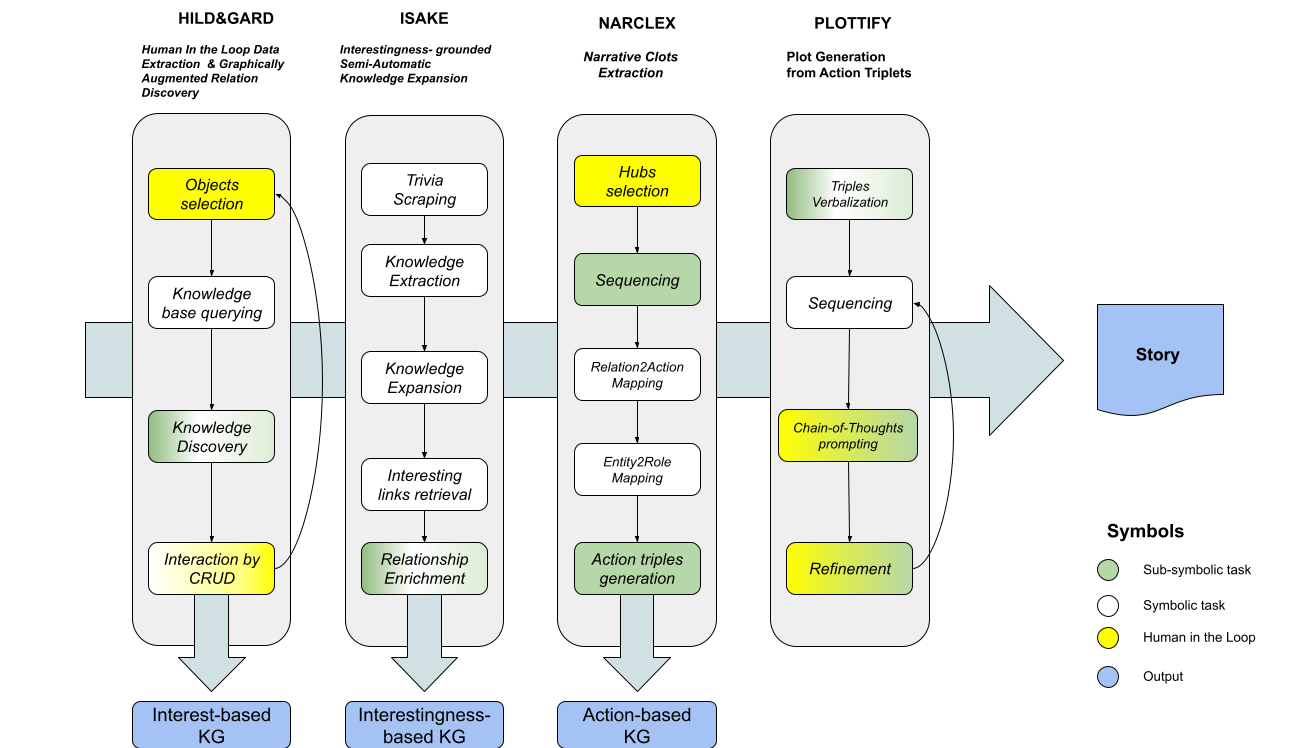

NARCLEX is the acronym for **NAR**rative **CL**ots **EX**tractor. It takes in input the output of the previous module, the *Enriched Knowledge Graph* (ISAAKx), and provides in output *Narrative Clots*. They are defined as sequences of particular actions extracted from the general relationships and entities, that are suitable to be seminal material for a more complex narrative. This is achieved by assigning to every entity a synset of categories/roles, and to every relationship a synset of related actions. Then, among all possible combinations, only the most relevant are selected. In this way, the transition from a *synchronic* to a *diachronic* transition is ensured.

A principled and intrinsic approach for detecting (in a narrative sense) interesting triples, and potentially interesting paths, has been provided only for the *dbo:WikiPageWikiLink* relationships. The proposed workflow pitifully succumbs to such a possibility, therefore the task of selection has to be performed analogically.

The purpose of this operation is to test the LLM performance in generating stories starting from different granularities (Interest-based Knowledge Graph --: Serendipity-based Narrative Knowledge Graph --: Action-based Knowledge Graph). Furthermore, being actions grounded in the real life, they are more keen to be improved and connected by means of common-sense reasoners, enhancing consistency and richness of the generated story: the generation phase will also test the validity of this assumption.

The present workflow is powered by Tony Veale's *Scealextric* and *Thesaurus-Rex*. Adjectives for the entities and properties for their roles are extracted from the latter, while the action sequences from the former.

The output of this workflow is a .csv file containing entities, related adjectives, actions (as subjects) and actions (as objects).

# **Input KG Parsing and Analysis**

In [2]:
!pip install python-louvain

With this codelet the input Knowledge Graph is parsed and preliminarly analysed to reduce the scope of application for the next processings.

Each subgraph is scored based on:


*   How well-connected its entities are (degree centrality)

*   How important it is for connecting different parts of the story (betweenness)


*   Its global importance in the narrative (PageRank)
The cohesiveness of its community structure

The Narrative Clot shall have as additional constraint to contain the initial two seed-entities upon which the whole KG has been built (see HILDEGARD). Nevertheless, this cannot be the smallest hub, but must be a larger one (yet, not the largest) containing the seed-entities, who are further linked by etherogeneous relationships and entities.


In [3]:
import networkx as nx
import pandas as pd
import community.community_louvain as community_louvain
from collections import defaultdict
from typing import Dict, List, Tuple, Set
import numpy as np
from urllib.parse import unquote
from difflib import SequenceMatcher

def align_homonym_entities(df: pd.DataFrame, output_file: str = "aligned_knowledge_graph.csv") -> pd.DataFrame:
    """
    Align homonym entities in the knowledge graph, considering both URIs and non-URI entities.
    Uses fuzzy matching to identify similar entities.

    Args:
        df: DataFrame with subject, predicate, object columns
    Returns:
        DataFrame with aligned entities
    """
    def normalize_entity(entity: str) -> str:
        """Normalize entity names for comparison"""
        
        if entity.startswith('http://'):
            # Extract the last part of the URI and decode
            entity = unquote(entity.split('/')[-1]).replace('_', ' ').lower()
        return entity.strip().lower()

    def are_similar(entity1: str, entity2: str, threshold: float = 0.85) -> bool:
        """Check if two entities are similar using fuzzy matching"""
        norm1 = normalize_entity(entity1)
        norm2 = normalize_entity(entity2)
        return SequenceMatcher(None, norm1, norm2).ratio() > threshold

    # Create mapping dictionary for aligned entities
    entity_mapping = {}
    all_entities = set(df['subject'].unique()) | set(df['object'].unique())

    # Build entity clusters
    entity_clusters = []
    processed_entities = set()

    for entity in all_entities:
        if entity in processed_entities:
            continue

        cluster = {entity}
        processed_entities.add(entity)

        # Find similar entities
        for other_entity in all_entities:
            if other_entity not in processed_entities and are_similar(entity, other_entity):
                cluster.add(other_entity)
                processed_entities.add(other_entity)

        entity_clusters.append(cluster)

    # Create mapping using the most detailed entity (preferring URIs) as canonical form
    for cluster in entity_clusters:
        canonical = max(cluster, key=lambda x: len(x) + (2 if x.startswith('http://') else 0))
        for entity in cluster:
            entity_mapping[entity] = canonical

    # Apply mapping to DataFrame
    df_aligned = df.copy()
    df_aligned['subject'] = df_aligned['subject'].map(lambda x: entity_mapping.get(x, x))
    df_aligned['object'] = df_aligned['object'].map(lambda x: entity_mapping.get(x, x))

    if output_file:
        df_aligned.to_csv(output_file, sep=';', index=False, header=False)
        print(f"Aligned knowledge graph exported to {output_file}")

    return df_aligned

def select_optimal_narrative_clot(G: nx.Graph, seed_entities: List[str], narrative_scores: Dict[str, float]) -> nx.Graph:
    """
    Select the optimal narrative clot based on size and connectivity constraints.
    Must contain seed entities and be a medium-to-large sized hub.

    Args:
        G: Complete knowledge graph
        seed_entities: List of seed entity URIs
        narrative_scores: Dict of narrative scores for nodes
    Returns:
        Selected optimal subgraph
    """
    # First ensure we can connect the seed entities
    connecting_nodes = set()

    # Add paths between seed entities
    for i, source in enumerate(seed_entities):
        for target in seed_entities[i+1:]:
            try:
                paths = list(nx.all_shortest_paths(G, source, target))
                for path in paths:
                    connecting_nodes.update(path)
            except nx.NetworkXNoPath:
                print(f"Warning: No path between {source} and {target}")
                continue

    if not connecting_nodes:
        return None

    # Expand the connecting subgraph to include more context
    expanded_nodes = connecting_nodes.copy()
    for node in connecting_nodes:
        expanded_nodes.update(G.neighbors(node))

    # Create initial subgraph
    subgraph = G.subgraph(expanded_nodes).copy()

    # Filter connected components containing seed entities
    valid_subgraphs = []
    for component in nx.connected_components(subgraph):
        sg = subgraph.subgraph(component).copy()
        if all(seed in sg.nodes() for seed in seed_entities):
            valid_subgraphs.append(sg)

    if not valid_subgraphs:
        return None

    # Sort by size
    valid_subgraphs.sort(key=lambda x: len(x.nodes()))

    # Select medium-to-large subgraph (exclude smallest 25% and largest 25%)
    n = len(valid_subgraphs)
    lower_idx = n // 4
    upper_idx = (n * 3) // 4

    candidate_subgraphs = valid_subgraphs[lower_idx:upper_idx]

    if not candidate_subgraphs:
        return valid_subgraphs[len(valid_subgraphs)//2]  # Take middle if range is too small

    # Among candidates, select the one with highest heterogeneous connectivity
    def compute_heterogeneity_score(sg: nx.Graph) -> float:
        # Count distinct relationship types
        relation_types = set(d['relation'] for _, _, d in sg.edges(data=True))
        # Compute ratio of nodes that aren't seed entities
        non_seed_ratio = (len(sg.nodes()) - len(seed_entities)) / len(sg.nodes())
        return len(relation_types) * non_seed_ratio

    return max(candidate_subgraphs, key=compute_heterogeneity_score)

def extract_connecting_subgraph(G: nx.Graph, entities: List[str], max_path_length: int = 3) -> nx.Graph:
    """
    Extract a subgraph that connects the specified entities through shortest paths.
    This helps us understand the narrative relationships between entities of interest.

    Args:
        G: The complete knowledge graph
        entities: List of entity URIs to connect
        max_path_length: Maximum length of paths to consider

    Returns:
        A subgraph containing paths between the specified entities
    """
    all_paths_nodes = set()

    # Find paths between each pair of entities
    for i, source in enumerate(entities):
        for target in entities[i+1:]:
            try:
                paths = list(nx.all_simple_paths(G, source, target, cutoff=max_path_length))
                for path in paths:
                    all_paths_nodes.update(path)
            except nx.NetworkXNoPath:
                print(f"No path found between {source} and {target}")
                continue

    # Extract the subgraph containing all paths
    return G.subgraph(all_paths_nodes).copy() if all_paths_nodes else None

def find_event_sequences(G: nx.Graph, subgraph_nodes: Set[str]) -> List[List[str]]:
    """
    Find sequences of events connected by hasSubEvent relationships within a set of nodes.
    This function helps us identify temporal narratives in the knowledge graph.

    Args:
        G: The complete knowledge graph
        subgraph_nodes: Set of nodes to search within

    Returns:
        List of event sequences found
    """
    EVENT_RELATION = "http://semanticweb.cs.vu.nl/2009/11/sem#hasSubEvent"
    sequences = []
    visited = set()

    def follow_event_chain(current_event: str, current_sequence: List[str]):
        """Recursively follow hasSubEvent relationships to build event sequences."""
        current_sequence.append(current_event)
        visited.add(current_event)

        # Look for sub-events
        sub_events = []
        for _, target, data in G.edges(current_event, data=True):
            if (data.get('relation') == EVENT_RELATION and
                target in subgraph_nodes and
                target not in current_sequence):
                sub_events.append(target)

        if sub_events:
            for sub_event in sub_events:
                follow_event_chain(sub_event, current_sequence.copy())
        else:
            sequences.append(current_sequence)

        # Start from each unvisited node in the subgraph
        for node in subgraph_nodes:
            if node not in visited:
                follow_event_chain(node, [])

        return sequences

def compute_event_richness(G: nx.Graph, nodes: Set[str]) -> float:
    """
    Calculate how rich in event sequences a set of nodes is.
    This helps us prioritize subgraphs that contain more temporal narratives.
    """
    EVENT_RELATION = "http://semanticweb.cs.vu.nl/2009/11/sem#hasSubEvent"
    event_edges = sum(1 for u, v, data in G.edges(nodes, data=True)
                     if data.get('relation') == EVENT_RELATION)
    return event_edges / len(nodes) if nodes else 0

def compute_narrative_relevance(G: nx.Graph) -> Dict[str, float]:
    """
    Compute narrative relevance score for each node based on multiple metrics.
    """
    # Calculate various centrality metrics
    degree_cent = nx.degree_centrality(G)
    betweenness_cent = nx.betweenness_centrality(G)
    pagerank = nx.pagerank(G)

    # Find communities
    communities = community_louvain.best_partition(G)

    # Calculate community sizes
    community_sizes = defaultdict(int)
    for node, comm_id in communities.items():
        community_sizes[comm_id] += 1

    # Compute community importance (larger communities are more important)
    community_importance = {
        comm_id: size / len(G)
        for comm_id, size in community_sizes.items()
    }

    # Combine metrics into narrative relevance score
    narrative_scores = {}
    for node in G.nodes():
        # Get community of node
        comm_id = communities[node]

        # Combine metrics with weights
        score = (
            0.3 * degree_cent.get(node, 0) +  # Local importance
            0.3 * betweenness_cent.get(node, 0) +  # Bridge importance
            0.2 * pagerank.get(node, 0) +  # Global importance
            0.2 * community_importance[comm_id]  # Community importance
        )

        narrative_scores[node] = score

    return narrative_scores

def extract_narrative_subgraphs(
    file_path: str,
    important_entities: List[str],
    min_size: int = 3,
    max_size: int = 20,
    n_subgraphs: int = 3
) -> List[nx.Graph]:
    """
    Extract subgraphs with high narrative relevance, ensuring optimal narrative clot selection.
    """
    print("\nLoading and aligning knowledge graph...")

    # Read and align entities
    df = pd.read_csv(file_path, sep=';', header=None, names=['subject', 'predicate', 'object'])
    df_aligned = align_homonym_entities(df)

    # Create graph from aligned data
    G = nx.Graph()
    for _, row in df_aligned.iterrows():
        G.add_edge(row['subject'], row['object'], relation=row['predicate'])

    # Calculate narrative scores and communities
    narrative_scores = compute_narrative_relevance(G)
    communities = community_louvain.best_partition(G)

    # Extract initial subgraphs
    subgraphs = []

    # Find optimal narrative clot
    narrative_clot = select_optimal_narrative_clot(G, important_entities, narrative_scores)

    if narrative_clot:
        narrative_clot.graph['type'] = 'narrative_clot'
        narrative_clot.graph['narrative_score'] = np.mean([
            narrative_scores.get(node, 0) for node in narrative_clot.nodes()
        ])
        subgraphs.append(narrative_clot)

    # Group nodes by community
    community_nodes = defaultdict(list)
    for node, comm_id in communities.items():
        community_nodes[comm_id].append(node)

    # Calculate community scores with event richness bonus
    community_scores = {}
    for comm_id, nodes in community_nodes.items():
        if len(nodes) >= min_size and len(nodes) <= max_size:
            nodes_set = set(nodes)
            # Base score from narrative relevance
            avg_score = np.mean([narrative_scores[node] for node in nodes])

            # Event sequence bonus
            event_richness = compute_event_richness(G, nodes_set)

            # Entity presence bonus
            entity_bonus = sum(1 for entity in important_entities if entity in nodes_set)

            # Combined score
            community_scores[comm_id] = avg_score * (1 + 0.3 * event_richness + 0.2 * entity_bonus)

    # Select top communities
    top_communities = sorted(
        community_scores.items(),
        key=lambda x: x[1],
        reverse=True
    )[:n_subgraphs-1]

    # Create subgraphs
    narrative_subgraphs = []

    # Add other high-scoring community subgraphs
    for comm_id, score in top_communities:
        nodes = community_nodes[comm_id]
        subgraph = G.subgraph(nodes).copy()
        subgraph.graph['community_id'] = comm_id
        subgraph.graph['narrative_score'] = score
        subgraph.graph['key_entities'] = sorted(
            nodes,
            key=lambda x: narrative_scores[x],
            reverse=True
        )[:3]
        subgraph.graph['is_connecting'] = False
        subgraph.graph['event_sequences'] = find_event_sequences(
            G, set(nodes)
        )
        narrative_subgraphs.append(subgraph)
    print(f"\nFinished computing narrative subgraphs with event sequences{narrative_subgraphs}")
    return narrative_subgraphs


def extract_narrative_subgraphs_2(
    file_path: str,
    important_entities: List[str],
    min_size: int = 3,
    max_size: int = 20,
    n_subgraphs: int = 3
) -> List[nx.Graph]:
    """
    Extract subgraphs with high narrative relevance, ensuring:
    1. At least one subgraph connects the specified important entities
    2. Subgraphs contain rich event sequences where possible
    """
    print("\nComputing narrative subgraphs with event sequences...")

    G = load_graph_from_csv(file_path)

    # Calculate narrative scores and communities separately
    narrative_scores = compute_narrative_relevance(G)  # Get narrative scores
    communities = community_louvain.best_partition(G)  # Get communities

    # Find connecting subgraph for important entities
    connecting_subgraph = extract_connecting_subgraph(G, important_entities)


    if connecting_subgraph:
        print(f"\nFound connecting subgraph with {len(connecting_subgraph.nodes())} nodes")
        # Find event sequences in connecting subgraph
        sequences = find_event_sequences(G, set(connecting_subgraph.nodes()))
        if sequences:

          print(f"Found {len(sequences)} event sequences in connecting subgraph")
          for i, sequence in enumerate(sequences, 1):
              print(f"\nEvent sequence {i}:")
              for event in sequence:
                  print(f"  → {event}")

    # Group nodes by community
    community_nodes = defaultdict(list)
    for node, comm_id in communities.items():
        community_nodes[comm_id].append(node)

    # Calculate community scores with event richness bonus
    community_scores = {}
    for comm_id, nodes in community_nodes.items():
        if len(nodes) >= min_size and len(nodes) <= max_size:
            nodes_set = set(nodes)
            # Base score from narrative relevance
            avg_score = np.mean([narrative_scores[node] for node in nodes])

            # Event sequence bonus
            event_richness = compute_event_richness(G, nodes_set)

            # Entity presence bonus
            entity_bonus = sum(1 for entity in important_entities if entity in nodes_set)

            # Combined score
            community_scores[comm_id] = avg_score * (1 + 0.3 * event_richness + 0.2 * entity_bonus)

    # Select top communities
    top_communities = sorted(
        community_scores.items(),
        key=lambda x: x[1],
        reverse=True
    )[:n_subgraphs-1]

    # Create subgraphs
    narrative_subgraphs = []

    # Add connecting subgraph first if it exists
    if connecting_subgraph:
        connecting_subgraph.graph['community_id'] = 'connecting'
        connecting_subgraph.graph['narrative_score'] = np.mean([
            narrative_scores.get(node, 0) for node in connecting_subgraph.nodes()
        ])
        connecting_subgraph.graph['key_entities'] = important_entities
        connecting_subgraph.graph['is_connecting'] = True
        connecting_subgraph.graph['event_sequences'] = find_event_sequences(
            G, set(connecting_subgraph.nodes())
        )
        narrative_subgraphs.append(connecting_subgraph)

    # Add other high-scoring community subgraphs
    for comm_id, score in top_communities:
        nodes = community_nodes[comm_id]
        subgraph = G.subgraph(nodes).copy()
        subgraph.graph['community_id'] = comm_id
        subgraph.graph['narrative_score'] = score
        subgraph.graph['key_entities'] = sorted(
            nodes,
            key=lambda x: narrative_scores[x],
            reverse=True
        )[:3]
        subgraph.graph['is_connecting'] = False
        subgraph.graph['event_sequences'] = find_event_sequences(
            G, set(nodes)
        )
        narrative_subgraphs.append(subgraph)
    print(f"\nFinished computing narrative subgraphs with event sequences{narrative_subgraphs}")
    return narrative_subgraphs



def load_graph_from_csv(file_path: str) -> nx.Graph:
    """
    Load knowledge graph from a semicolon-separated CSV file.
    Each line should contain: subject;predicate;object
    """
    print("\nStarting to read the CSV file...")

    # Read CSV with semicolon separator
    try:
        # First, let's look at the raw data
        with open(file_path, 'r', encoding='utf-8') as f:
            print("\nFirst few lines of raw file:")
            for i, line in enumerate(f.readlines()[:5]):
                print(f"Line {i+1}: {repr(line)}")

        # Now read with pandas using semicolon separator
        df = pd.read_csv(file_path, sep=';', header=None, names=['subject', 'predicate', 'object'])
        print("\nFirst few rows of parsed DataFrame:")
        print(df.head())

      
        G = nx.Graph()

        # Add edges from DataFrame
        for _, row in df.iterrows():
            subject = str(row['subject']).strip()
            predicate = str(row['predicate']).strip()
            object_ = str(row['object']).strip()

            # Add edge to graph
            G.add_edge(subject, object_, relation=predicate)

            # Debug print for first few edges
            if _ < 5:
                print(f"\nAdding edge {_+1}:")
                print(f"From: {subject}")
                print(f"To: {object_}")
                print(f"Relation: {predicate}")

        print(f"\nFinal graph statistics:")
        print(f"Number of nodes: {len(G.nodes())}")
        print(f"Number of edges: {len(G.edges())}")

        # Print sample of nodes and edges
        print("\nSample of nodes (first 5):")
        for node in list(G.nodes())[:5]:
            print(f"Node: {node}")

        print("\nSample of edges (first 5):")
        for u, v, data in list(G.edges(data=True))[:5]:
            print(f"Edge: {u} --[{data['relation']}]--> {v}")

        return G

    except Exception as e:
        print(f"Error loading CSV: {str(e)}")
        raise

def print_subgraph_details(subgraph: nx.Graph, index: int, ret: str) -> List[str]:
    """Print detailed information about a subgraph, including event sequences."""
    print(f"\n{'='*80}")
    print(f"Subgraph {index} Analysis")
    print(f"{'='*80}")

    print(f"\nBasic Information:")
    print(f"Number of entities: {len(subgraph.nodes())}")
    print(f"Number of relationships: {len(subgraph.edges())}")
    print(f"Narrative score: {subgraph.graph.get('narrative_score', 'N/A'):.3f}")
    print(f"Is connecting subgraph: {subgraph.graph.get('is_connecting', False)}")

   
    if 'event_sequences' in subgraph.graph:
        sequences = subgraph.graph['event_sequences']
        if sequences:
          print(f"\nEvent Sequences Found: {len(sequences)}")
          for i, sequence in enumerate(sequences, 1):
              print(f"\nSequence {i}:")
              for event in sequence:
                  print(f"  → {event}")
    allent = []
    print("\nAll Entities:")
    for node in subgraph.nodes():
        allent.append(node)
        print(f"- {node}")
    allrel = []
    print("\nAll Relationships:")
    for u, v, data in subgraph.edges(data=True):
        rel = f"{u} --[{data.get('relation', 'related_to')}]--> {v}"
        print(rel)
        allrel.append(rel)
    if ret == "ent":
      return allent
    elif ret == "rel":
      return allrel

if __name__ == "__main__":
    file_path = "/content/enriched_knowledge_graph_triples.csv"
    important_entities = [
        "http://dbpedia.org/resource/Alexander_the_Great",
        "http://dbpedia.org/resource/Anubis"
    ]
    subgraphs = extract_narrative_subgraphs(file_path, important_entities)
    allrel = []
    allent = []
    for i, subgraph in enumerate(subgraphs, 1):
        allrel.append(print_subgraph_details(subgraph, i, "rel"))
        allent.append(print_subgraph_details(subgraph, i, "ent"))
    print(allrel)
    print(allent)
    subgraphs = extract_narrative_subgraphs_2(file_path, important_entities)
    allrel = []
    allent = []
    for i, subgraph in enumerate(subgraphs, 1):
        allrel.append(print_subgraph_details(subgraph, i, "rel"))
        allent.append(print_subgraph_details(subgraph, i, "ent"))
    print(allrel)
    print(allent)


Loading and aligning knowledge graph...
Aligned knowledge graph exported to aligned_knowledge_graph.csv

Finished computing narrative subgraphs with event sequences[<networkx.classes.graph.Graph object at 0x7c6237352a50>]

Subgraph 1 Analysis

Basic Information:
Number of entities: 11
Number of relationships: 10
Narrative score: 0.011
Is connecting subgraph: False

All Entities:
- 2019-05-21
- H U.S. President Zachary Taylor, who died 141 years earlier in 1850, is exhumed to discover whether or not his death was caused by arsenic poisoning, instead of acute gastrointestinal illness; no trace of arsenic is found.
- Washington becomes the first state to legalize human composting, the right to allow people to have their body turned into soil after death. The process is seen as an alternative to traditional cremations and burials.
- http://dbpedia.org/resource/Hungarian_language
- 1859-01-24
- http://dbpedia.org/resource/Metropolis
- http://dbpedia.org/resource/Black_Sea
- 1991-06-12
- ht

***Entity2Role Mapping***

In [4]:
!pip install SPARQLWrapper

In [5]:
from SPARQLWrapper import SPARQLWrapper, JSON
import re
from typing import List, Set
import csv

def parse_triples_from_nested_list(nested_list: List[List[str]]) -> List[Tuple[str, str, str]]:
    """
    Convert a nested list of triple strings into a flat list of triple tuples.

    This function processes strings in the format:
    "subject --[predicate]--> object"
    and converts them into (subject, predicate, object) tuples.

    Args:
        nested_list: A list of lists, where each inner list contains strings
                    representing triples in the format described above.

    Returns:
        A list of tuples, where each tuple contains (subject, predicate, object).

    Example:
        Input string: "http://dbpedia.org/resource/Anubis --[http://dbpedia.org/property/equivalent]--> http://dbpedia.org/resource/Hermes"
        Output tuple: ("http://dbpedia.org/resource/Anubis", "http://dbpedia.org/property/equivalent", "http://dbpedia.org/resource/Hermes")
    """
    # Pattern to extract the three components of a triple
    pattern = r"(.*?)\s+--\[(.*?)\]-->\s+(.*)"

    # Initialize our result list
    all_triples = []

    # Keep track of processing statistics
    processed_count = 0
    error_count = 0

    # Process each sublist in the nested list
    for sublist_index, sublist in enumerate(nested_list, 1):
        print(f"\nProcessing sublist {sublist_index} ({len(sublist)} triples)")

        # Process each triple string in the sublist
        for triple_str in sublist:
            try:
                # Try to match the pattern
                match = re.match(pattern, triple_str.strip())

                if match:
                    # Extract the components
                    subject = match.group(1).strip()
                    predicate = match.group(2).strip()
                    object_ = match.group(3).strip()

                    # Add the triple to our result list
                    triple = (subject, predicate, object_)
                    all_triples.append(triple)
                    processed_count += 1

                    # Debug output for the first few triples
                    if processed_count <= 3:
                        print(f"\nProcessed triple {processed_count}:")
                        print(f"Subject  : {subject}")
                        print(f"Predicate: {predicate}")
                        print(f"Object   : {object_}")
                else:
                    print(f"Warning: Could not parse triple: {triple_str}")
                    error_count += 1

            except Exception as e:
                print(f"Error processing triple: {triple_str}")
                print(f"Error details: {str(e)}")
                error_count += 1

    # Print summary statistics
    print(f"\nProcessing complete:")
    print(f"Total triples processed: {processed_count}")
    print(f"Successful conversions: {len(all_triples)}")
    print(f"Errors encountered: {error_count}")

    return all_triples

def extract_entities_from_nested_list(nested_list: List[List[str]]) -> Set[str]:
    """
    Extract unique entities from a nested list structure containing DBpedia resource URIs.

    This function takes a nested list where each inner list contains DBpedia resource URIs
    and returns a set of all unique entities. It also processes the URIs to extract
    readable entity names when needed.

    Args:
        nested_list: A list of lists, where each inner list contains DBpedia resource URIs.

    Returns:
        A set of unique entity URIs.

    Example:
        Input: [['http://dbpedia.org/resource/Anubis', 'http://dbpedia.org/resource/Zeus']]
        Output: {'http://dbpedia.org/resource/Anubis', 'http://dbpedia.org/resource/Zeus'}
    """
    # Initialize a set to store unique entities
    unique_entities = set()

    # Keep track of processing statistics
    total_processed = 0
    unique_count = 0

    print("Starting entity extraction...")

    # Process each sublist in the nested structure
    for sublist_index, sublist in enumerate(nested_list, 1):
        print(f"\nProcessing sublist {sublist_index} ({len(sublist)} entities)")

        # Process each entity URI in the current sublist
        for entity_uri in sublist:
            try:
                # Clean up the URI by stripping whitespace
                clean_uri = entity_uri.strip()

                # Add the entity to our set (duplicates are automatically handled)
                if clean_uri not in unique_entities:
                    unique_entities.add(clean_uri)
                    unique_count += 1

                    # Extract the entity name from the URI for display
                    entity_name = clean_uri.split('/')[-1].replace('_', ' ')
                    entity_name = unquote(entity_name)  # Handle URL encoding

                    print(f"Found new entity: {entity_name}")

                total_processed += 1

            except Exception as e:
                print(f"Error processing entity: {entity_uri}")
                print(f"Error details: {str(e)}")
        if sublist_index == 1:
          break

    # Print summary statistics
    print(f"\nExtraction complete:")
    print(f"Total entities processed: {total_processed}")
    print(f"Unique entities found: {len(unique_entities)}")

    return unique_entities


def extract_entities_from_triples(triples: List[str]) -> Set[str]:
    """
    Extract unique entities from a list of triples represented as strings.

    This function processes triples in the format:
    "entity1 --[relationship]--> entity2"
    and returns a set of all unique entities found.

    Args:
        triples: List of strings, where each string represents a triple in the format
                "subject --[predicate]--> object"

    Returns:
        Set of unique entity URIs found in the triples

    Example:
        Input triple: "http://dbpedia.org/resource/Anubis --[http://dbpedia.org/property/equivalent]--> http://dbpedia.org/resource/Hermes"
        Extracted entities: {"http://dbpedia.org/resource/Anubis", "http://dbpedia.org/resource/Hermes"}
    """
    entities = set()

    # Pattern to match entities in the triple format
    # This matches everything before --[ for subject and after ]--> for object
    pattern = r"(.*?)\s+--\[.*?\]-->\s+(.*)"

    for triple in triples:
        try:
            # Find matches using the pattern
            match = re.match(pattern, triple.strip())

            if match:
                # Extract subject and object
                subject = match.group(1).strip()
                object_ = match.group(2).strip()

                # Add both entities to the set
                entities.add(subject)
                entities.add(object_)
        except Exception as e:
            print(f"Error processing triple: {triple}")
            print(f"Error details: {str(e)}")

    # Print some summary information
    print(f"\nExtracted {len(entities)} unique entities from {len(triples)} triples")

    return entities


def entity_to_role_mapping(entity_uri):
    """
    Query DBpedia for rdf:type properties (including YAGO) of a given entity and verbalize them.

    Args:
    entity_uri (str): The DBpedia URI of the entity to query.

    Returns:
    list: A list of verbalized roles (types) for the entity.
    """
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    sparql.setReturnFormat(JSON)

    query = f"""
    SELECT DISTINCT ?type
    WHERE {{
        <{entity_uri}> rdf:type ?type .
        FILTER(STRSTARTS(STR(?type), "http://dbpedia.org/ontology/") ||
               STRSTARTS(STR(?type), "http://dbpedia.org/class/yago/"))
    }}
    """

    sparql.setQuery(query)

    try:
        results = sparql.query().convert()
        roles = []

        for result in results["results"]["bindings"]:
            type_uri = result["type"]["value"]

            # Determine if it's a DBpedia or YAGO type
            if "dbpedia.org/ontology/" in type_uri:
                prefix = "DBpedia: "
                role = re.split("[/#]", type_uri)[-1]
            elif "dbpedia.org/class/yago/" in type_uri:
                prefix = "YAGO: "
                role = re.split("[/#]", type_uri)[-1]
                role = role.replace("Wikicat", "")  # Remove 'Wikicat' prefix from YAGO classes
            else:
                continue  # Skip if it's neither DBpedia nor YAGO

            # Convert CamelCase to space-separated words
            role = re.sub("([a-z])([A-Z])", r"\1 \2", role).lower()

            # Remove any numbers (often present in YAGO classes)
            role = re.sub(r'\d+$', '', role).strip()

            roles.append((role)) #prefix eliminated

        # Verbalize the roles
        if roles:
            verbalized_roles = [f"{role}" for role in roles]
            return verbalized_roles
        else:
            return ["No specific roles found for this entity in DBpedia or YAGO ontologies."]

    except Exception as e:
        return [f"An error occurred: {str(e)}"]

def save_to_csv(data, filename='entity_roles.csv'):
    """
    Save the given data to a CSV file.

    Args:
    data (list): List of tuples where each tuple contains (entity_uri, role).
    filename (str): Name of the file to save the CSV to. Default is 'entity_roles.csv'.
    """
    with open(filename, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        # Write the header
        writer.writerow(['Entity URI', 'Role'])
        # Write the data
        for entity_uri, roles in data:
            for role in roles:
                writer.writerow([entity_uri, role])

if __name__ == "__main__":
    # Assuming 'allent' is your nested list of triples or entities
    # Replace 'allent' with your actual variable or data source
    entities = extract_entities_from_nested_list(allent)

    # List to store results before saving
    results = []

    for entity_uri in entities:
        roles = entity_to_role_mapping(entity_uri)
        results.append((entity_uri, roles))
        print(f"Roles for {entity_uri}:")
        for role in roles:
            print(f"- {role}")

    # Save results to CSV
    save_to_csv(results)
    print(f"\nResults have been saved to 'entity_roles.csv'.")

Starting entity extraction...

Processing sublist 1 (7 entities)
Found new entity: Hor-Aha
Found new entity: Hermes
Found new entity: List of pharaohs
Found new entity: Djer
Found new entity: Ancient Greek religion
Found new entity: Alexander the Great
Found new entity: Anubis

Extraction complete:
Total entities processed: 7
Unique entities found: 7
Roles for http://dbpedia.org/resource/Hor-Aha:
- causal agent
- holder
- living thing
- object
- officeholder
- official
- organism
- owner
- person
- physical entity
- worker
- yago legal actor
- yago legal actor geo
- skilled worker
- whole
- person
- animal
- eukaryote
- species
- pharaoh
- royalty
Roles for http://dbpedia.org/resource/Hermes:
- characters in the iliad
- characters in the odyssey
- lgbtthemes in mythology
- trickster deities
- ability
- abstraction
- belief
- cognition
- communication
- content
- creativity
- defamation
- deity
- disparagement
- disrespect
- fictional character
- imaginary being
- imagination
- message


***Check if entity is in expanded_weights, connect it to list of adjectives***

In [6]:
!pip install transformers

In [14]:
import re
from typing import Dict, List, Optional
import csv
from pathlib import Path
import pandas as pd
import torch
from transformers import pipeline, AutoTokenizer

class EntityAdjectiveExtractor:
    def __init__(self, text_file_path: str, adjectives_file: str = '/content/adjectives.txt'):
        self.text_file_path = text_file_path
        self.entity_adjectives = self._parse_text_file()
        #self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        #self.model.to(self.device)
        self.tokenizer = AutoTokenizer.from_pretrained("joeddav/xlm-roberta-large-xnli")
        self.text_file_path = text_file_path
        self.classifier = pipeline("zero-shot-classification",
                                 model="joeddav/xlm-roberta-large-xnli",
                                 device=0 if torch.cuda.is_available() else -1)
        self.candidate_labels = self._load_adjectives(adjectives_file)

    def _load_adjectives(self, adjectives_file: str) -> List[str]:
        try:
            with open(adjectives_file, 'r', encoding='utf-8') as f:
                return [line.strip() for line in f if line.strip()]
        except Exception as e:
            print(f"Error loading adjectives: {e}")
            return []

    def generate_adjectives(self, entity: str) -> List[tuple]:
        entity_name = entity.split('/')[-1].replace('_', ' ')
        sequence = f"{entity_name} is best described as being"

        result = self.classifier(
            sequence,
            candidate_labels=self.candidate_labels,
            multi_label=True
        )

        sorted_results = sorted(zip(result['labels'], result['scores']),
                              key=lambda x: x[1], reverse=True)[:20]
        return [(adj, int(score * 100)) for adj, score in sorted_results]

    def _parse_text_file(self) -> Dict[str, List[tuple]]:
        entity_data = {}
        try:
            with open(self.text_file_path, 'r', encoding='utf-8') as file:
                for line in file:
                    if match := re.match(r'\d+\.\s+(\w+)\s+\[(.*?)\]', line.strip()):
                        entity_name, adj_list = match.groups()
                        adj_scores = re.findall(r'(\w+)_person\((\d+)\)', adj_list)
                        entity_data[entity_name] = [(adj, int(score)) for adj, score in adj_scores]
        except Exception as e:
            print(f"Error parsing file: {e}")
        return entity_data

    def process_uris(self, uris: List[str]) -> Dict[str, List[tuple]]:
        results = {}
        for uri in uris:
            entity_name = uri.split('/')[-1]
            if entity_name in self.entity_adjectives:
                results[entity_name] = self.entity_adjectives[entity_name]
            else:
                adj_scores = self.generate_adjectives(entity_name)
                results[entity_name] = adj_scores
                self.entity_adjectives[entity_name] = adj_scores
        return results

def process_entities(entity_uris: List[str], text_file_path: str, output_file: str) -> Dict[str, List[tuple]]:
    extractor = EntityAdjectiveExtractor(text_file_path)
    results = extractor.process_uris(entity_uris)

    pd.DataFrame([{
        'entity': entity,
        'adjectives': '|'.join(adj for adj, _ in adjectives),
        'scores': '|'.join(str(score) for _, score in adjectives)
    } for entity, adjectives in results.items()]).to_csv(output_file, index=False)

    return results

# Example usage
if __name__ == "__main__":
    # Example URIs

    test_uris = extract_entities_from_nested_list(allent)

    # Process entities and save results
    results = process_entities(
        entity_uris=test_uris,
        text_file_path="/content/expanded_weights.txt",
        output_file="entity_adjectives.csv"
    )


    # Print example of results
    for entity, adjectives in results.items():
        print(f"\nEntity: {entity}")
        print("Top 10 adjectives with scores:")
        for adj, score in adjectives[:10]:
            print(f"- {adj}: {score}")

Starting entity extraction...

Processing sublist 1 (7 entities)
Found new entity: Hor-Aha
Found new entity: Hermes
Found new entity: List of pharaohs
Found new entity: Djer
Found new entity: Ancient Greek religion
Found new entity: Alexander the Great
Found new entity: Anubis

Extraction complete:
Total entities processed: 7
Unique entities found: 7


Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu



Entity: Hor-Aha
Top 5 adjectives with scores:
- opportune: 99
- quintessential: 99
- vociferous: 99
- noteworthy: 99
- eccentric: 99
- wary: 99
- heroic: 99
- helpful: 98
- agitated: 98
- unstable: 98

Entity: Hermes
Top 5 adjectives with scores:
- opportune: 99
- quintessential: 99
- helpful: 99
- noteworthy: 99
- brilliant: 99
- heroic: 98
- formidable: 98
- sublime: 98
- insightful: 98
- charismatic: 97

Entity: Djer
Top 5 adjectives with scores:
- opportune: 99
- quintessential: 99
- noteworthy: 99
- helpful: 99
- brilliant: 99
- sublime: 98
- insightful: 98
- formidable: 98
- charismatic: 97
- masterful: 97

Entity: List_of_pharaohs
Top 5 adjectives with scores:
- opportune: 99
- helpful: 99
- noteworthy: 99
- illustrious: 98
- insightful: 97
- creative: 97
- perceptive: 97
- transcendent: 96
- versatile: 95
- beguiling: 95

Entity: Ancient_Greek_religion
Top 5 adjectives with scores:
- opportune: 99
- quintessential: 98
- noteworthy: 98
- helpful: 96
- perceptive: 91
- insightfu

***Extract actions from quality inventory***

In [15]:
import pandas as pd
from typing import Dict, List, Tuple
import csv
from pathlib import Path
import chardet
import openpyxl

def detect_file_encoding(file_path: str) -> str:
    """
    Detect the encoding of a file using chardet.

    Args:
        file_path: Path to the file to check

    Returns:
        The detected encoding, defaulting to 'utf-8' if detection fails
    """
    try:
        # Read the first few thousand bytes to detect encoding
        with open(file_path, 'rb') as file:
            raw_data = file.read(10000)

        # Detect the encoding
        result = chardet.detect(raw_data)
        encoding = result['encoding']
        confidence = result['confidence']

        print(f"Detected encoding: {encoding} (confidence: {confidence:.2f})")
        return encoding
    except Exception as e:
        print(f"Error detecting encoding: {str(e)}")
        return 'utf-8'

def load_csv_with_encoding(file_path: str, try_encodings: List[str] = None) -> pd.DataFrame:
    """
    Try to load a CSV file with different encodings until successful.

    Args:
        file_path: Path to the CSV file
        try_encodings: List of encodings to try, in order

    Returns:
        Pandas DataFrame containing the CSV data
    """
    if try_encodings is None:
        # Common encodings to try
        try_encodings = ['utf-8', 'latin1', 'iso-8859-1', 'cp1252']

    # First try detected encoding
    detected_encoding = detect_file_encoding(file_path)
    if detected_encoding:
        try_encodings.insert(0, detected_encoding)

    # Try each encoding
    for encoding in try_encodings:
        try:
            print(f"Trying to read file with {encoding} encoding...")
            df = pd.read_csv(file_path, encoding=encoding)
            print(f"Successfully read file with {encoding} encoding")
            return df
        except UnicodeDecodeError:
            print(f"Failed to read with {encoding} encoding")
        except Exception as e:
            print(f"Other error with {encoding} encoding: {str(e)}")

    raise ValueError(f"Could not read file with any of the attempted encodings: {try_encodings}")

class AdjectiveActionMatcher:
    def __init__(self, qualities_csv_path: str):
        """Initialize with qualities CSV containing action mappings."""
        self.qualities_data = self._load_qualities(qualities_csv_path)

    def _load_qualities(self, csv_path: str) -> Dict[str, Dict]:
        """Load the qualities-actions mapping CSV with encoding detection."""
        qualities = {}

        try:
            # Load Excel file using openpyxl
            df = pd.read_excel(csv_path, engine='openpyxl') # Use read_excel with openpyxl engine
            print(f"\nLoading qualities from {csv_path}")

            # Clean up column names - remove any BOM and extra whitespace
            df.columns = [col.strip().strip('\ufeff') for col in df.columns]

            # Process each row
            for _, row in df.iterrows():
                # Get the quality name and clean it
                quality = str(row['Quality']).strip()

                # Handle potential NaN values in action columns
                actions_a = row['When Property of A']
                actions_b = row['When Property of B']

                # Convert to string and split only if not NaN
                actions_a = ([act.strip() for act in str(actions_a).split(',')]
                           if pd.notna(actions_a) else [])
                actions_b = ([act.strip() for act in str(actions_b).split(',')]
                           if pd.notna(actions_b) else [])

                qualities[quality] = {
                    'count': row['Count'],
                    'actions_a': actions_a,
                    'actions_b': actions_b
                }

            print(f"Loaded {len(qualities)} qualities with actions")

            # Print sample of loaded data for verification
            sample_quality = next(iter(qualities))
            print(f"\nSample data for quality '{sample_quality}':")
            print(f"Count: {qualities[sample_quality]['count']}")
            print(f"Actions as subject: {', '.join(qualities[sample_quality]['actions_a'])}")
            print(f"Actions as object: {', '.join(qualities[sample_quality]['actions_b'])}")

            return qualities

        except Exception as e:
            print(f"Error loading qualities CSV: {str(e)}")
            raise

    def match_and_save(self, entity_adjectives: Dict[str, List[Tuple[str, int]]],
                          output_file: str):
            """
            Match adjectives with their actions and save results to CSV.

            Args:
                entity_adjectives: Dictionary of entities and their adjectives with scores
                output_file: Path to save the resulting CSV
            """
            rows = []
            matches_found = 0
            total_adjectives = 0

            for entity, adjectives in entity_adjectives.items():
                print(f"\nProcessing {entity}")

                for adj, score in adjectives:
                    total_adjectives += 1

                    if adj in self.qualities_data:
                        matches_found += 1
                        quality_info = self.qualities_data[adj]

                        rows.append({
                            'entity': entity,
                            'adjective': adj,
                            'adjective_score': score,
                            'quality_usage_count': quality_info['count'],
                            'actions_as_subject': '|'.join(quality_info['actions_a']),
                            'actions_as_object': '|'.join(quality_info['actions_b'])
                        })

            if rows:
                
                df = pd.DataFrame(rows)
                df = df.sort_values(['entity', 'adjective_score'], ascending=[True, False])
                df.to_csv(output_file, index=False)

               
                print(f"\nResults summary:")
                print(f"Total adjectives processed: {total_adjectives}")
                print(f"Matches found: {matches_found}")
                print(f"Match rate: {(matches_found/total_adjectives)*100:.1f}%")
                print(f"Results saved to: {output_file}")
            else:
                print("No matches found to save")


def process_adjectives_with_actions(
    entity_adjectives_csv: str,
    qualities_csv: str,
    output_file: str
):
    """
    Main function to process entity adjectives from CSV and match with actions.

    Args:
        entity_adjectives_csv: Path to CSV with entity adjectives
        qualities_csv: Path to CSV with quality-action mappings
        output_file: Path to save the output CSV
    """
    try:
        
        print("\nLoading entity adjectives...")
        df_entities = load_csv_with_encoding(entity_adjectives_csv)
        entity_data = {}

        for _, row in df_entities.iterrows():
            entity = row['entity']
            adjectives = row['adjectives'].split('|')
            scores = [int(score) for score in row['scores'].split('|')]
            entity_data[entity] = list(zip(adjectives, scores))

        if not entity_data:
            print("No entity data loaded. Exiting.")
            return

        # Initialize matcher and process adjectives
        matcher = AdjectiveActionMatcher(qualities_csv)
        matcher.match_and_save(entity_data, output_file)

    except Exception as e:
        print(f"Error in main processing: {str(e)}")
        raise

    def match_and_save(self, entity_adjectives: Dict[str, List[Tuple[str, int]]],
                      output_file: str):
        """
        Match adjectives with their actions and save results to CSV.

        Args:
            entity_adjectives: Dictionary of entities and their adjectives with scores
            output_file: Path to save the resulting CSV
        """
        rows = []
        matches_found = 0
        total_adjectives = 0

        for entity, adjectives in entity_adjectives.items():
            print(f"\nProcessing {entity}")

            for adj, score in adjectives:
                total_adjectives += 1

                if adj in self.qualities_data:
                    matches_found += 1
                    quality_info = self.qualities_data[adj]

                    rows.append({
                        'entity': entity,
                        'adjective': adj,
                        'adjective_score': score,
                        'quality_usage_count': quality_info['count'],
                        'actions_as_subject': '|'.join(quality_info['actions_a']),
                        'actions_as_object': '|'.join(quality_info['actions_b'])
                    })

        if rows:
            
            df = pd.DataFrame(rows)
            df = df.sort_values(['entity', 'adjective_score'], ascending=[True, False])
            df.to_csv(output_file, index=False)

           
            print(f"\nResults summary:")
            print(f"Total adjectives processed: {total_adjectives}")
            print(f"Matches found: {matches_found}")
            print(f"Match rate: {(matches_found/total_adjectives)*100:.1f}%")
            print(f"Results saved to: {output_file}")
        else:
            print("No matches found to save")

def process_adjectives_with_actions(
    entity_adjectives_csv: str,
    qualities_csv: str,
    output_file: str
):
    """
    Main function to process entity adjectives from CSV and match with actions.

    Args:
        entity_adjectives_csv: Path to CSV with entity adjectives
        qualities_csv: Path to CSV with quality-action mappings
        output_file: Path to save the output CSV
    """
    # Load entity adjectives from CSV
    # Use a helper function to load entity adjectives (replace with your implementation)
    entity_data = load_entity_adjectives(entity_adjectives_csv)

    if not entity_data:
        print("No entity data loaded. Exiting.")
        return

    # Initialize matcher and process adjectives
    matcher = AdjectiveActionMatcher(qualities_csv)
    matcher.match_and_save(entity_data, output_file)

def load_entity_adjectives(entity_adjectives_csv: str):
    """Load entity adjectives from a CSV file.

    Args:
        entity_adjectives_csv: Path to CSV with entity adjectives

    Returns:
        A dictionary mapping entities to their adjectives and scores.
    """
    print("\nLoading entity adjectives...")
    df_entities = load_csv_with_encoding(entity_adjectives_csv)
    entity_data = {}

    for _, row in df_entities.iterrows():
        entity = row['entity']
        adjectives = row['adjectives'].split('|')
        scores = [int(score) for score in row['scores'].split('|')]
        entity_data[entity] = list(zip(adjectives, scores))

    return entity_data

if __name__ == "__main__":
    # Process the CSVs
    process_adjectives_with_actions(
        entity_adjectives_csv="/content/entity_adjectives.csv",
        qualities_csv="/content/Veale's quality inventory.xlsx",
        output_file="entity_adjectives_actions.csv"
    )


Loading entity adjectives...
Detected encoding: ascii (confidence: 1.00)
Trying to read file with ascii encoding...
Successfully read file with ascii encoding

Loading qualities from /content/Veale's quality inventory.xlsx
Loaded 1970 qualities with actions

Sample data for quality 'witty':
Count: 89
Actions as subject: entertain, charm, seduce, insult, satirize
Actions as object: are_entertained_by, are_charmed_by, are_seduced_by, are_insulted_by, are_heckled_by

Processing Hor-Aha

Processing Hermes

Processing Djer

Processing List_of_pharaohs

Processing Ancient_Greek_religion

Processing Alexander_the_Great

Processing Anubis

Results summary:
Total adjectives processed: 230
Matches found: 167
Match rate: 72.6%
Results saved to: entity_adjectives_actions.csv


/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
